In [1]:
import os, sys, time, datetime, json, random
import numpy as np

import torch
import torch.utils.data as data

from easydict import EasyDict as edict
import pickle

import copy
import matplotlib.pyplot as plt
%matplotlib inline

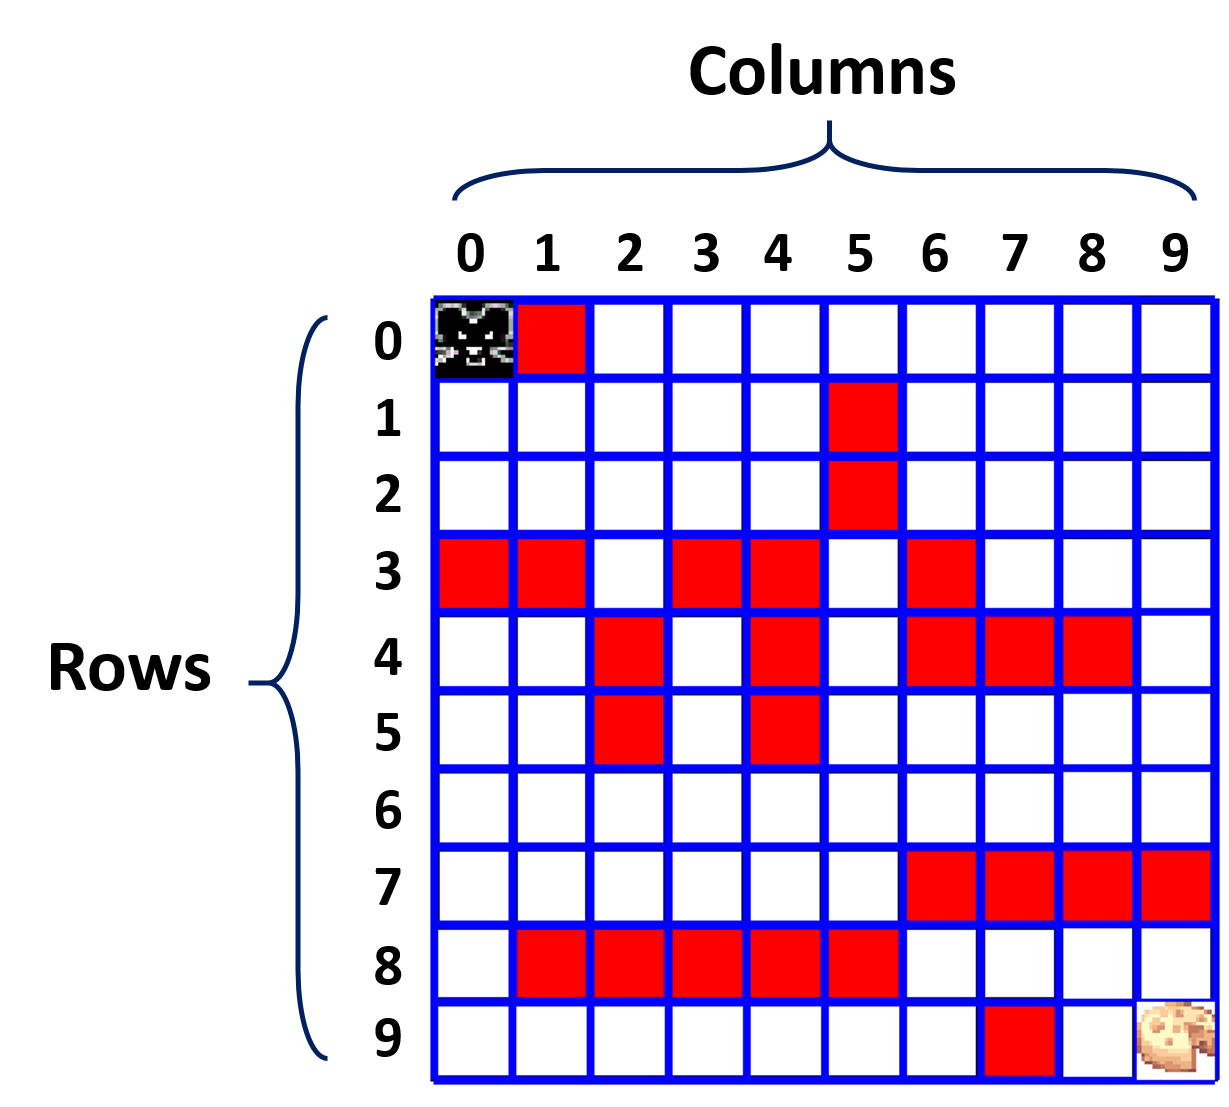

- 0 - 左
- 1 - 向上
- 2 - 右
- 3 - 向下
- 每次移动都会花费老鼠 -0.04 分
- 奶酪，给予 1.0 分
- 封锁的单元格-0.75 分，动作不会被执行
- 迷宫边界之外的行为：-0.8 分，动作不会被执行
- 已经访问过的单元格，-0.25 分
- 总奖励低于负阈值：(-0.5 * maze.size)，lose

In [338]:
visited_mark = 0.8  # Cells visited by the rat will be painted by gray 0.8
end_mark = 1.5
rat_mark = 0.5      # The current rat cell will be painteg by gray 0.5
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)

# Exploration factor
epsilon = 0.1

In [339]:
random.randint(0, 1)

1

In [340]:
# import random

# def generate_gridworld(n, prob=0.8):
#     """
#     生成大小为n x n的随机Gridworld，其中prob控制1出现的频率。
#     返回值是一个包含n个列表的列表，每个列表包含n个随机数（0或1）。
#     """
#     gridworld = [[int(random.random() < prob) for j in range(n)] for i in range(n)]
#     return gridworld

# def find_path(gridworld, start, end):
#     """
#     使用深度优先搜索算法查找从start到end的路径。
#     如果找到了一条路径，则返回True，否则返回False。
#     """
#     visited = set()
#     stack = [start]
#     while stack:
#         current = stack.pop()
#         if current == end:
#             return True
#         if current in visited:
#             continue
#         visited.add(current)
#         x, y = current
#         neighbors = [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]
#         for neighbor in neighbors:
#             i, j = neighbor
#             if i < 0 or i >= len(gridworld) or j < 0 or j >= len(gridworld[0]):
#                 continue
#             if gridworld[i][j] == 0:
#                 continue
#             stack.append((i, j))
#     return False

# def generate_solvable_gridworld(n):
#     """
#     生成一个可解的大小为n x n的Gridworld。
#     返回值是一个元组，包含生成的Gridworld、起点和终点。
#     """
#     while True:
#         gridworld = generate_gridworld(n)
#         start = (random.randint(0, n-1), random.randint(0, n-1))
#         end = (random.randint(0, n-1), random.randint(0, n-1))
#         if gridworld[start[0]][start[1]] == 1 and gridworld[end[0]][end[1]] == 1 and start != end and find_path(gridworld, start, end):
#             return gridworld, start, end

# # 示例代码
# gridworld, start, end = generate_solvable_gridworld(8)
# print(gridworld)
# print("start:", start)
# print("end:", end)

# train_set = {'gridworld':[],
#             'start':[],
#             'end':[]}

# test_set = {'gridworld':[],
#             'start':[],
#             'end':[]}

# for i in range(6400):
#     gridworld, start, end = generate_solvable_gridworld(8)
#     train_set['gridworld'].append(gridworld)
#     train_set['start'].append(start)
#     train_set['end'].append(end)

# # 将字典保存到文件中
# with open("gridworld3x3_train_dict.pickle", "wb") as f:
#     pickle.dump(train_set, f)

In [341]:
# 从文件中加载字典
with open("gridworld3x3_train_dict.pickle", "rb") as f:
    train_dict = pickle.load(f)

with open("gridworld3x3_test_dict.pickle", "rb") as f:
    test_dict = pickle.load(f)

In [342]:
len(test_dict['gridworld'])

800

## Q-maze

In [343]:
50/(1.5)

33.333333333333336

In [344]:
1/(abs(1-0) + abs(1-0))

0.5

In [345]:
# maze is a 2d Numpy array of floats between 0.0 to 1.0
# 1.0 corresponds to a free cell, and 0.0 an occupied cell
# rat = (row, col) initial rat position (defaults to (0,0))

class Qmaze(object):
    def __init__(self, maze, rat=None, target=None, max_Tstep=38):
        # 允许的最大步数
        self.max_Tstep = max_Tstep
        self.action_space = [0, 1, 2, 3]
        # 初始化迷宫
        self._maze = np.array(maze)
        nrows, ncols = self._maze.shape
        
        # 初始化空格list，maze为1表示空格，为0表示墙体
        # self.free_cells = [(r,c) for r in range(nrows) for c in range(ncols) if self._maze[r,c] == 1.0]
        # self.target = (nrows-1, ncols-1)   # target cell where the "cheese" is
            
        # 放置老鼠并初始化参数
        self.target = target
        self.rat = rat
        state, info = self.reset()
        # return state, info

    def reset(self):
        
        # 生成终点位置
        if self.target is None:
            self.target = self.get_random_position()
            
        if self.rat is None:
            self.rat = self.get_random_position()
            while self.rat == self.target:
                self.rat = self.get_random_position()
        
        
        # 检查老鼠和终点是否为空
        if self._maze[self.target[0], self.target[1]] == 0.0:
            raise Exception("Invalid maze: target cell cannot be blocked!")
        if self._maze[self.rat[0], self.rat[1]] == 0.0:
            raise Exception("Invalid Rat Location: must sit on a free cell")
            
        self.maze = np.copy(self._maze)
        nrows, ncols = self.maze.shape
        row, col = self.rat
        self.maze[row, col] = rat_mark
        # 初始状态
        self.state = (row, col, 'start')
        # 设置最低奖励阈值
        self.min_reward = -0.5 * self.maze.size
        # 初始化总奖励
        self.total_reward = 0
        self.visited = list()
        self.total_Tstep = 0
        
        return self.observe(), self.game_status()

    def update_state(self, action):
        '''
            input: action [0, 1, 2, 3] [L, U, R, D]
        '''
        nrows, ncols = self.maze.shape
        nrow, ncol, nmode = rat_row, rat_col, mode = self.state
        
        # 如果老鼠访问的是空格，则记录
        if self.maze[rat_row, rat_col] > 0.0:
            self.visited.append((rat_row, rat_col))  # mark visited cell

        # 获取所有可能执行的动作
        valid_actions = self.valid_actions()
        # print('valid_actions', valid_actions)
        
        # 如果没有可以执行的动作（被围住了），则状态为 blocked，位置不变
        if not valid_actions:
            nmode = 'blocked'
            print('blocked')
        # 如果需要执行的动作在可执行动作列表中，那么状态为有效，并相应执行动作
        elif action in valid_actions:
            nmode = 'valid'
            if action == LEFT:
                ncol -= 1
            elif action == UP:
                nrow -= 1
            if action == RIGHT:
                ncol += 1
            elif action == DOWN:
                nrow += 1
        # 如果需要执行的动作不在可执行动作列表中（撞墙），位置不变
        else:                  # invalid action, no change in rat position
            nmode = 'invalid'
            
        self.total_Tstep += 1  # 每次执行动作+1
        # new state
        self.state = (nrow, ncol, nmode)

    def get_reward(self):
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        
        reward = 0
        rl = 0
        rg = 0
        # print('rat_row, rat_col, self.target', rat_row, rat_col, self.target)
        if rat_row== self.target[0] and rat_col == self.target[1]:
            rl = 1  # 奶酪，给予 1.0 分
        elif mode == 'blocked':
            rl = self.min_reward - 1
        elif mode == 'invalid':
            rl = -0.75  # 撞墙-0.75 分，动作不会被执行
        elif (rat_row, rat_col) in self.visited:
            rl = -0.25  # 访问已经访问过的单元格，-0.25 分
        elif mode == 'valid':
            rl = -0.04  # 每次移动都会花费老鼠 -0.04 分
        
        if rl!= 1:
            rg = 0.04/(abs(self.state[0]-self.target[0]) + abs(self.state[1]-self.target[1]))
        # print(rl, rg)
        
        reward = rl + rg
        
        return reward

    def act(self, action):
        self.update_state(action)
        reward = self.get_reward()
        self.total_reward += reward
        status = self.game_status()
        envstate = self.observe()
        return envstate, reward, status
    
    def step(self, action):
        envstate, reward, status = self.act(action)
        observation = envstate
        done = self.is_game_done()
        info = status
        return observation, reward, done, info

    def observe(self):
        # canvas = self.draw_env()
        canvas = self.get_observation()
        envstate = canvas.reshape((1, -1))
        return envstate

    def draw_env(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        # clear all visual marks
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > 0.0:
                    canvas[r,c] = 1.0
        # draw the rat
        row, col, valid = self.state
        canvas[row, col] = rat_mark
        canvas[self.target[0], self.target[1]] = end_mark
        return canvas

    def game_status(self):
        if self.total_Tstep > self.max_Tstep:
        # if self.total_reward < self.min_reward:
            return 'lose'
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        if rat_row== self.target[0] and rat_col == self.target[1]:
            return 'win'

        return 'not_over'
    
    def is_game_done(self):
        game_status = self.game_status()
        
        if game_status == 'not_over':
            return False
        elif game_status == 'win' or game_status == 'lose':
            return True
        
        return -1

    def valid_actions(self, cell=None):
        # 默认验证当前位置
        if cell is None:
            row, col, mode = self.state
        else:
            row, col = cell
        actions = copy.deepcopy(self.action_space)
        nrows, ncols = self.maze.shape
        # 如果在第0行，则不能向上走；如果在最后一行，则不能向下走
        if row == 0:
            actions.remove(1)
        elif row == nrows-1:
            actions.remove(3)
        # 列-左右
        if col == 0:
            actions.remove(0)
        elif col == ncols-1:
            actions.remove(2)

        # 如果不在最左列，而左边是墙，则不能向左；右边同理
        if row>0 and self.maze[row-1,col] == 0.0:
            actions.remove(1)
        if row<nrows-1 and self.maze[row+1,col] == 0.0:
            actions.remove(3)

        # 上下同理
        if col>0 and self.maze[row,col-1] == 0.0:
            actions.remove(0)
        if col<ncols-1 and self.maze[row,col+1] == 0.0:
            actions.remove(2)

        # 返回所有可能执行的动作
        return actions
    
    def get_random_position(self):
        maze = self._maze
        
        ROWS = len(maze)
        COLS = len(maze[0])

        # 随机选择一个点
        row = random.randint(0, ROWS - 1)
        col = random.randint(0, COLS - 1)
        
        while maze[row][col] != 1:
            # 随机选择一个点
            row = random.randint(0, ROWS - 1)
            col = random.randint(0, COLS - 1)
        
        return row, col
    
    def get_observation(self, size=3):
        maze = self.draw_env()
        row, col, _ = self.state
        # 获取maze的行列数
        ROWS = len(maze)
        COLS = len(maze[0])

        # 初始化结果二维数组
        result = [[0 for _ in range(size)] for _ in range(size)]

        # 将以指定点为中心指定尺寸范围的观测值存入结果二维数组
        for i in range(row-size//2, row+size//2+1):
            for j in range(col-size//2, col+size//2+1):
                if i < 0 or i >= ROWS or j < 0 or j >= COLS:
                    # 如果超出边界，则填充为1
                    result[i-row+size//2][j-col+size//2] = 0.0
                else:
                    result[i-row+size//2][j-col+size//2] = maze[i][j]

        # 返回结果二维数组
        result = np.array(result)
        result[size//2][size//2] = 0.5
        return result

In [346]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    rat_row, rat_col, _ = qmaze.state
    end_row, end_col = qmaze.target
    canvas[rat_row, rat_col] = 0.3   # rat cell
    canvas[end_row, end_col] = 0.7 # cheese cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

In [347]:
maze, rat, target = train_dict['gridworld'][0], train_dict['start'][0], train_dict['end'][0]

In [348]:
# maze = [
#     [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
#     [ 1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.],
#     [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
#     [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
#     [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
#     [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
#     [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
#     [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
# ]
# maze =  np.array([
#     [ 1.,  0.,  1.,  1.,  1.,  1.,  1., 1.],
#     [ 1.,  1.,  1.,  0.,  0.,  1.,  0., 0.],
#     [ 1.,  0.,  1.,  1.,  1.,  1.,  0., 0.],
#     [ 1.,  1.,  1.,  1.,  0.,  1.,  1., 1.],
#     [ 1.,  0.,  0.,  1.,  1.,  1.,  1., 1.],
#     [ 1.,  0.,  1.,  1.,  1.,  1.,  1., 1.],
#     [ 1.,  1.,  1.,  0.,  1.,  1.,  1., 1.],
#     [ 1.,  1.,  1.,  0.,  1.,  1.,  1., 1.],
# ])

maze = np.array(maze)*1.0

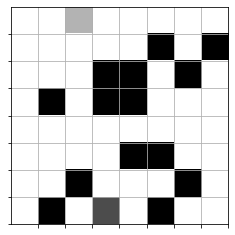

In [349]:
qmaze = Qmaze(maze, rat, target)
# canvas, reward, game_over = qmaze.act(DOWN)
# print("reward=", reward)
show(qmaze)

In [350]:
qmaze.draw_env()

array([[1. , 1. , 1.5, 1. , 1. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 1. , 1. , 0. , 1. , 0. ],
       [1. , 1. , 1. , 0. , 0. , 1. , 0. , 1. ],
       [1. , 0. , 1. , 0. , 0. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 1. , 0. , 0. , 1. , 1. ],
       [1. , 1. , 0. , 1. , 1. , 1. , 0. , 1. ],
       [1. , 0. , 1. , 0.5, 1. , 0. , 1. , 1. ]])

In [351]:
qmaze.observe()

array([[0. , 1. , 1. , 1. , 0.5, 1. , 0. , 0. , 0. ]])

-0.03428571428571429 -0.03428571428571429 not_over
-0.06761904761904762 -0.03333333333333333 not_over
-0.09961904761904762 -0.032 not_over
-0.8416190476190476 -0.742 not_over
-0.8716190476190476 -0.03 not_over
-0.8982857142857142 -0.026666666666666665 not_over
-0.9182857142857143 -0.02 not_over
-0.9182857142857143 0.0 not_over
0.08171428571428574 1 win


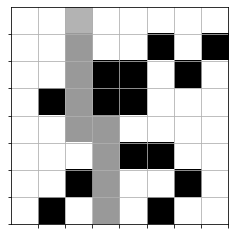

In [352]:
canvas, reward, game_over = qmaze.act(UP)  # move right
print(qmaze.total_reward, reward, game_over)
canvas, reward, game_over = qmaze.act(UP)  # move right
print(qmaze.total_reward, reward, game_over)
canvas, reward, game_over = qmaze.act(UP)  # move up
print(qmaze.total_reward, reward, game_over)
canvas, reward, game_over = qmaze.act(UP)  # move up
print(qmaze.total_reward, reward, game_over)
canvas, reward, game_over = qmaze.act(LEFT)  # move up
print(qmaze.total_reward, reward, game_over)
canvas, reward, game_over = qmaze.act(UP)  # move up
print(qmaze.total_reward, reward, game_over)
canvas, reward, game_over = qmaze.act(UP)  # move up
print(qmaze.total_reward, reward, game_over)
canvas, reward, game_over = qmaze.act(UP)  # move up
print(qmaze.total_reward, reward, game_over)
canvas, reward, game_over = qmaze.act(UP)  # move up
print(qmaze.total_reward, reward, game_over)
show(qmaze)

In [353]:
qmaze.state

(0, 2, 'valid')

In [354]:
qmaze.target

(0, 2)

In [355]:
qmaze.is_game_done()

True

In [356]:
qmaze.visited

[(7, 3), (6, 3), (5, 3), (4, 3), (4, 3), (4, 2), (3, 2), (2, 2), (1, 2)]

## DQN

In [357]:
import torch
import torch.nn as nn
import torch.optim as optim
import math

class DQN(nn.Module):
    def __init__(self, maze_size, num_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(maze_size, 32)
        self.prelu1 = nn.ReLU()
        self.layer2 = nn.Linear(32, 32)
        self.prelu2 = nn.ReLU()
        self.output_layer = nn.Linear(32, num_actions)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.prelu1(x)
        x = self.layer2(x)
        x = self.prelu2(x)
        x = self.output_layer(x)
        return x


In [358]:
from collections import namedtuple, deque
import matplotlib
import matplotlib.pyplot as plt
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    
def plot_rewards(episode_rewards, show_result=False, title='Training...'):
    plt.figure(1)
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel('Rewards')
    plt.plot(rewards_t.numpy())
    
    # Take 100 episode averages and plot them too
    if len(rewards_t) >= 100:
        means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99)-28.5, means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [359]:
# 动作选取
def select_action(state):
    global steps_done
    sample = random.random()
    
    # 随着进行，eps_threshold逐渐降低
    # eps_threshold = EPS_END + (EPS_START - EPS_END) * \
    #     math.exp(-1. * steps_done / EPS_DECAY)
    eps_threshold = 0.1
    steps_done += 1
    
    # 常规情况选择价值最高的动作
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    
    # 当随机值超过阈值时，随机选取 - exploration
    else:
        # 探索时只探索可能的动作，增加探索效率？
        return torch.tensor([[random.choice(env.valid_actions())]], device=device, dtype=torch.long)

In [360]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    
    # 离线学习，从记忆池中抽取回忆
    transitions = memory.sample(BATCH_SIZE)
    # print(transitions)
    
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    
    # 将([a, 1], [b, 2], [c, 3])转化为([a, b, c], [1, 2, 3])，一个zip的trick
    # 然后将他们分别放到tuples with names里（'state', 'action', 'next_state', and 'reward'）
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    # 计算非最终状态的掩码，并将批处理元素连接起来
    # (最终状态是指模拟结束后的状态)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    # 模型计算Q价值，我们根据价值选择动作
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    # 当前奖励+下一个状态的奖励，更新Q. 如果下一个状态为最终状态，则仅有当前奖励
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch  
    # print(expected_state_action_values)

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    # torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

# optimize_model()

In [361]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

In [362]:
# ss = []
# es = []
# EPS_DECAY = 10
# for i in range(1000):
#     sample = random.random()
#     eps_threshold = EPS_END + (EPS_START - EPS_END) * \
#             math.exp(-1. * i / EPS_DECAY)
#     # eps_threshold = 1.0 / (i + 1)
#     ss.append(sample)
#     es.append(eps_threshold)

# exploit = 0
# for i in range(1000):
#     if ss[i] > es[i]:
#         exploit += 1
# plt.plot(ss)
# plt.plot(es)
# print(exploit, exploit/1000)

In [363]:
len(train_dict['gridworld'])

6400

In [439]:
from tqdm import trange

def evaluation(test_dict):
    win = 0
    episode_rewards = []
    
    num_r = len(test_dict['start'])
    
    for j in trange(800):
        maze, rat, target = test_dict['gridworld'][j], test_dict['start'][j], test_dict['end'][j]
        maze = np.array(maze)*1.0
    
        env = Qmaze(maze, rat, target)
        # Initialize the environment and get it's state
        state, info = env.reset()
        # Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity
        state = torch.tensor(state, dtype=torch.float32, device=device)

        done = False
        while not done:
            action = policy_net(state).max(1)[1].view(1, 1)  # 选择一个动作
            # random.choice(env.valid_actions())
            observation, reward, done, info = env.step(action.item())  # 执行动作，返回{下一个观察值、奖励、是否结束、是否提前终止}
            # reward = torch.tensor([reward], device=device)
            # print(int(action[0][0]))
            # print(observation, reward, done, info)
            # print()
            if done:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device)  # 如果没有终止则继续记录下一个状态

            # Store the transition in memory
            # memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state
            
        episode_rewards.append(env.total_reward)
        if info == 'win':
            win += 1
    
    
    win_rate = win / 800
    
    show(env)
    print(env.visited)
    print(env.state)
    print(env.total_reward)
    
    return episode_rewards, win_rate

# win_rate = evaluation(10)
# print(win_rate)

In [365]:
# i_episode=0

In [366]:
# maze_set, rat_set, target_set = train_dict['gridworld'], train_dict['start'], train_dict['end']

In [367]:
# maze_set = torch.Tensor(maze_set)
# rat_set = np.array(rat_set)
# target_set = np.array(target_set)

In [368]:
ENV_NAME = 'grid'

folder_name = f"runs/{ENV_NAME}/" + time.asctime(time.gmtime()).replace(" ", "_").replace(":", "_")
os.makedirs('runs/', exist_ok=True)
os.makedirs(f'runs/{ENV_NAME}/', exist_ok=True)
os.makedirs(folder_name, exist_ok=True)

In [412]:
# BATCH_SIZE是指从重放缓冲区采样的转换数
# GAMMA是上一节中提到的折扣系数
# EPS_START是EPSILON的起始值
# EPS_END是epsilon的最终值
# EPS_DECAY 控制epsilon的指数衰减率，越高意味着衰减越慢
# TAU是目标网络的更新率
# LR是AdamW优化器的学习率
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
num_episodes = 10000
steps_done = 0
# sync_target_net_freq = 1e4



# 初始化环境
env = Qmaze(maze, rat, target)
# 重置环境获取信息
state, info = env.reset()

n_observations = state.size
state = torch.Tensor(state).to(device)

policy_net = DQN(n_observations, num_actions).to(device)
target_net = DQN(n_observations, num_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.Adam(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(1000)

episode_rewards = []

maze_set, rat_set, target_set = train_dict['gridworld'], train_dict['start'], train_dict['end']
maze_set = np.array(maze_set)*1.0
rat_set = np.array(rat_set)
target_set = np.array(target_set)


for j in range(3):
    for i_episode in range(6400):
        # 每张图训练10次
        # 读取训练数据
        maze, rat, target = maze_set[i_episode], rat_set[i_episode], target_set[i_episode]

        # 初始化环境
        env = Qmaze(maze, rat, target)
        
        # Initialize the environment and get it's state
        state, info = env.reset()
        # Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity
        state = torch.tensor(state, dtype=torch.float32, device=device)

        done = False
        while not done:
            action = select_action(state)  # 选择一个动作
            # random.choice(env.valid_actions())
            observation, reward, done, _ = env.step(action.item())  # 执行动作，返回{下一个观察值、奖励、是否结束、是否提前终止}
            reward = torch.tensor([reward], device=device)

            if done:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device)  # 如果没有终止则继续记录下一个状态

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            optimize_model()

            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()

            # if (steps_done % sync_target_net_freq) == 0:
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)
                # target_net.load_state_dict(policy_net_state_dict)


        episode_rewards.append(env.total_reward)

        # win_rate = evaluation()
        # print(win_rate)
        # plot_rewards(episode_rewards) #, title = 'Training... WinRate='+str(win_rate))
        
        # if win_rate == 1:
        #     print('win_rate 100%!')
        #     break

<Figure size 432x288 with 0 Axes>

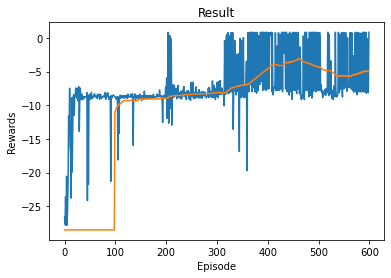

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [434]:
# plot_rewards(episode_rewards, True)

[(2, 6), (1, 6), (1, 5), (1, 4), (1, 3), (2, 3), (2, 2), (2, 1)]
(1, 1, 'valid')
0.8446666666666667


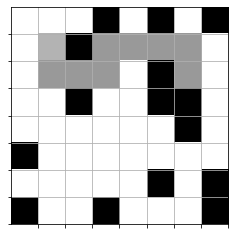

In [435]:
# show(env)
print(env.visited)
print(env.state)
print(env.total_reward)

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.05it/s]


[(3, 4), (4, 4), (5, 4), (6, 4), (7, 4), (6, 4), (7, 4), (6, 4), (7, 4), (6, 4), (7, 4), (6, 4), (7, 4), (6, 4), (7, 4), (6, 4), (7, 4), (6, 4), (7, 4), (6, 4), (7, 4), (6, 4), (7, 4), (6, 4), (7, 4), (6, 4), (7, 4), (6, 4), (7, 4), (6, 4), (7, 4), (6, 4), (7, 4), (6, 4), (7, 4), (6, 4), (7, 4), (6, 4), (7, 4)]
(6, 4, 'valid')
-8.662476190476193


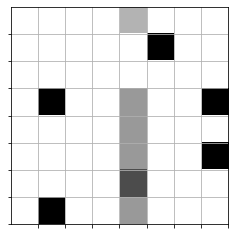

In [443]:
episode_rewards_eval, win_rate = evaluation(test_dict)

In [444]:
# print(np.mean(episode_rewards_eval), win_rate)

-7.988831202131203 0.16875


In [98]:
history = {
    'train':{
        'episode_rewards':episode_rewards,
    },
    'eval':{
        'episode_rewards_eval':episode_rewards_eval,
        'win_rate':win_rate
    },
}

In [104]:
# 将字典保存到文件中
with open(folder_name+"/history.pickle", "wb") as f:
    pickle.dump(history, f)

In [106]:
torch.save(policy_net.state_dict(), folder_name+'/model.pt')

In [ ]:
# # Initialize the environment and get it's state
# state, info = env.reset()

In [ ]:
# show(env)

In [145]:
!jupyter nbconvert --to python GridWorld-dy_part_wend-Copy1.ipynb

[NbConvertApp] Converting notebook GridWorld-dy_part_wend-Copy1.ipynb to python
[NbConvertApp] Writing 36605 bytes to GridWorld-dy_part_wend-Copy1.py


In [ ]:
# def play_game(model, qmaze, rat_cell):
#     qmaze.reset(rat_cell)
#     envstate = qmaze.observe()
#     while True:
#         prev_envstate = envstate
#         # get next action
#         q = model.predict(prev_envstate)
#         action = np.argmax(q[0])

#         # apply action, get rewards and new state
#         envstate, reward, game_status = qmaze.act(action)
#         if game_status == 'win':
#             return True
#         elif game_status == 'lose':
#             return False
        
# def completion_check(model, qmaze):
#     for cell in qmaze.free_cells:
#         if not qmaze.valid_actions(cell):
#             return False
#         if not play_game(model, qmaze, cell):
#             return False
#     return True

In [ ]:
# class Experience(object):
#     def __init__(self, model, max_memory=100, discount=0.95):
#         self.model = model
#         self.max_memory = max_memory
#         self.discount = discount
#         self.memory = list()
#         self.num_actions = num_actions

#     def remember(self, episode):
#         # episode = [envstate, action, reward, envstate_next, game_over]
#         # memory[i] = episode
#         # envstate == flattened 1d maze cells info, including rat cell (see method: observe)
#         self.memory.append(episode)
#         if len(self.memory) > self.max_memory:
#             del self.memory[0]

#     def predict(self, envstate):
#         envstate = torch.Tensor(envstate)
#         return self.model(envstate)

#     def get_data(self, data_size=10):
#         env_size = self.memory[0][0].shape[1]   # envstate 1d size (1st element of episode)
#         mem_size = len(self.memory)
#         data_size = min(mem_size, data_size)
#         inputs = torch.zeros((data_size, env_size))
#         targets = torch.zeros((data_size, self.num_actions))
#         for i, j in enumerate(np.random.choice(range(mem_size), data_size, replace=False)):
#             envstate, action, reward, envstate_next, game_over = self.memory[j]
#             inputs[i] = envstate
#             # There should be no target values for actions not taken.
#             targets[i] = self.predict(envstate)
#             # Q_sa = derived policy = max quality env/action = max_a' Q(s', a')
#             Q_sa = torch.max(self.predict(envstate_next))
#             print(targets, reward)
#             if game_over:
#                 targets[i, action] = reward
#             else:
#                 # reward + gamma * max_a' Q(s', a')
#                 targets[i, action] = reward + self.discount * Q_sa
#             print(targets, reward)
#             return
#         return inputs, targets
    
#     def get_data_tensor(self, data_size=10):
#         env_size = self.memory[0][0].shape[1]  # envstate 1d size (1st element of episode)
#         mem_size = len(self.memory)
#         data_size = min(mem_size, data_size)
#         inputs = torch.zeros((data_size, env_size))
#         targets = torch.zeros((data_size, self.num_actions))

#         sample_indices = np.random.choice(range(mem_size), data_size, replace=False)
#         sampled_memory = [self.memory[j] for j in sample_indices]
       
#         envstates = torch.cat([m[0] for m in sampled_memory])
#         actions = torch.LongTensor([m[1] for m in sampled_memory]).view(-1, 1)
#         rewards = torch.FloatTensor([m[2] for m in sampled_memory]).view(-1, 1)
#         envstates_next = torch.cat([m[3] for m in sampled_memory])
#         game_over = torch.FloatTensor([m[4] for m in sampled_memory]).view(-1, 1)

#         inputs.copy_(envstates)
#         # There should be no target values for actions not taken.
#         targets.copy_(self.predict(envstates).data)
#         # print(torch.max(self.predict(envstates_next)))
#         # print(self.predict(envstates_next).shape)
#         # print(envstates_next.shape)
#         Q_sa = torch.max(self.predict(envstates_next), dim=1, keepdim=True)[0]
#         print('Q_sa', Q_sa)
#         # print(targets.gather(1, actions).view(-1, 1))
#         print(targets, rewards)
#         targets.gather(1, actions).view(-1, 1).copy_(rewards)
#         print(targets.gather(1, actions).view(-1, 1))
#         print(targets, rewards)
#         # return
#         mask = (game_over == 0)
#         masked_next_state_values = Q_sa * mask.float()
#         targets.gather(1, actions).view(-1, 1).add_(masked_next_state_values)

#         return inputs, targets

In [ ]:
# maze.shape

In [ ]:
# model = Model(maze.size, num_actions)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# loss = nn.MSELoss()

In [ ]:
# model

In [ ]:
# model = build_model(maze)
# qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)

In [ ]:
# # This is a small utility for printing readable time strings:
# def format_time(seconds):
#     if seconds < 400:
#         s = float(seconds)
#         return "%.1f seconds" % (s,)
#     elif seconds < 4000:
#         m = seconds / 60.0
#         return "%.2f minutes" % (m,)
#     else:
#         h = seconds / 3600.0
#         return "%.2f hours" % (h,)

In [ ]:
# global epsilon
# n_epoch = 1
# max_memory = 8*maze.size
# data_size = 32
# weights_file = ""
# name = 'model'
# start_time = datetime.datetime.now()

# # If you want to continue training from a previous model,
# # just supply the h5 file name to weights_file option
# if weights_file:
#     print("loading weights from file: %s" % (weights_file,))
#     model.load_weights(weights_file)

# # Construct environment/game from numpy array: maze (see above)
# qmaze = Qmaze(maze)

# # Initialize experience replay object
# experience = Experience(model, max_memory=max_memory)

# win_history = []   # history of win/lose game
# n_free_cells = len(qmaze.free_cells)
# hsize = qmaze.maze.size//2   # history window size
# win_rate = 0.0
# imctr = 1

# for epoch in range(n_epoch):
#     loss = 0.0
#     rat_cell = random.choice(qmaze.free_cells)
#     qmaze.reset(rat_cell)
#     game_over = False

#     # get initial envstate (1d flattened canvas)
#     envstate = qmaze.observe()  # (1, 64)
#     envstate = torch.Tensor(envstate)

#     n_episodes = 0
#     while not game_over:
#         valid_actions = qmaze.valid_actions()
#         if not valid_actions: break
#         prev_envstate = envstate  # 上一个时刻的状态
        
#         # Get next action
#         if np.random.rand() < epsilon:
#             action = random.choice(valid_actions)
#         else:
#             action = np.argmax(experience.predict(prev_envstate).cpu().detach().numpy())
            
#         # Apply action, get reward and new envstate
#         envstate, reward, game_status = qmaze.act(action)
#         envstate = torch.Tensor(envstate)
        
#         if game_status == 'win':
#             win_history.append(1)
#             game_over = True
#         elif game_status == 'lose':
#             win_history.append(0)
#             game_over = True
#         else:
#             game_over = False

#         # Store episode (experience)
#         episode = [prev_envstate, action, reward, envstate, game_over]
#         experience.remember(episode)
#         n_episodes += 1
        
#         # Train neural network model
#         inputs, targets = experience.get_data(data_size=data_size)

#         # break
        
# inputs, inputs.shape, targets, targets.shape






# #         h = model.fit(
# #             inputs,
# #             targets,
# #             epochs=8,
# #             batch_size=16,
# #             verbose=0,
# #         )
# #         loss = model.evaluate(inputs, targets, verbose=0)

In [ ]:
# for epoch in range(n_epoch):
#     loss = 0.0
#     rat_cell = random.choice(qmaze.free_cells)
#     qmaze.reset(rat_cell)
#     game_over = False

#     # get initial envstate (1d flattened canvas)
#     envstate = qmaze.observe()

#     n_episodes = 0
#     while not game_over:
#         valid_actions = qmaze.valid_actions()
#         if not valid_actions: break
#         prev_envstate = envstate
#         # Get next action
#         if np.random.rand() < epsilon:
#             action = random.choice(valid_actions)
#         else:
#             action = np.argmax(experience.predict(prev_envstate))

#         # Apply action, get reward and new envstate
#         envstate, reward, game_status = qmaze.act(action)
#         if game_status == 'win':
#             win_history.append(1)
#             game_over = True
#         elif game_status == 'lose':
#             win_history.append(0)
#             game_over = True
#         else:
#             game_over = False

#         # Store episode (experience)
#         episode = [prev_envstate, action, reward, envstate, game_over]
#         experience.remember(episode)
#         n_episodes += 1

#         # Train neural network model
#         inputs, targets = experience.get_data(data_size=data_size)
#         h = model.fit(
#             inputs,
#             targets,
#             epochs=8,
#             batch_size=16,
#             verbose=0,
#         )
#         loss = model.evaluate(inputs, targets, verbose=0)

#     if len(win_history) > hsize:
#         win_rate = sum(win_history[-hsize:]) / hsize

#     dt = datetime.datetime.now() - start_time
#     t = format_time(dt.total_seconds())
#     template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
#     print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
#     # we simply check if training has exhausted all free cells and if in all
#     # cases the agent won
#     if win_rate > 0.9 : epsilon = 0.05
#     if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
#         print("Reached 100%% win rate at epoch: %d" % (epoch,))
#         break

# # Save trained model weights and architecture, this will be used by the visualization code
# h5file = name + ".h5"
# json_file = name + ".json"
# model.save_weights(h5file, overwrite=True)
# with open(json_file, "w") as outfile:
#     json.dump(model.to_json(), outfile)
# end_time = datetime.datetime.now()
# dt = datetime.datetime.now() - start_time
# seconds = dt.total_seconds()
# t = format_time(seconds)
# print('files: %s, %s' % (h5file, json_file))
# print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
